In [1]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

# Loading the data
df = pd.read_csv('googleplaystore.csv')

In [2]:
%matplotlib inline
sns.set(style='darkgrid')
sns.set_palette('PuBuGn_d')

In [3]:
# The best way to fill missing values might be using the median instead of mean.
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [4]:
# Check the record  of unreasonable value which is 1.9
i = df[df['Category'] == '1.9'].index
df.loc[i]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0,NaN


In [5]:
df = df.drop(i)
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

In [6]:
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])
# Price cealning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))
df['Type'] = pd.get_dummies(df['Type'])
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))
k_indices = df['Size'].loc[df['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df.loc[k_indices,'Size'] = converter
df['Size'] = df['Size'].apply(lambda x: x.strip('M'))
df[df['Size'] == 'Varies with device'] = 0
df['Size'] = df['Size'].astype(float)

In [7]:
# Split data into training and testing sets
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
y = df['Rating']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [9]:
model = KNeighborsRegressor(n_neighbors=50)

In [10]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=50)

In [11]:
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 92.55%'

In [12]:
X_train

,App,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,...,cat_SPORTS,cat_TRAVEL_AND_LOCAL,cat_TOOLS,cat_PERSONALIZATION,cat_PRODUCTIVITY,cat_PARENTING,cat_WEATHER,cat_VIDEO_PLAYERS,cat_NEWS_AND_MAGAZINES,cat_MAPS_AND_NAVIGATION
10802,4308,185,28.0,10000,1,0,4,52,1.438837e+09,1.300,...,0,0,0,0,0,0,0,0,0,0
2943,0,0,0.0,0,0,0,0,0,0.000000e+00,0.000,...,0,0,0,0,0,0,0,0,0,0
8547,4427,942,3.0,100000,1,0,1,91,1.484806e+09,1.140,...,0,0,0,0,0,0,0,0,0,0
3247,6436,45838,16.0,50000000,1,0,1,108,1.532495e+09,7.610,...,0,0,1,0,0,0,0,0,0,0
2755,5354,315908,52.0,10000000,1,0,1,96,1.533100e+09,5.211,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9372,3902,13388,7.1,500000,1,0,1,6,1.440392e+09,2.050,...,0,0,0,0,0,0,0,0,0,0
7291,2010,1,2.3,100,1,0,1,81,1.485238e+09,1.050,...,0,0,0,0,0,0,0,0,0,0
1344,5135,77563,39.0,10000000,1,0,1,62,1.532322e+09,3.640,...,0,0,0,0,0,0,0,0,0,0
7293,1996,6,1.1,1000,1,0,1,82,1.533186e+09,1.200,...,0,0,0,0,1,0,0,0,0,0


In [13]:
from sklearn.preprocessing import StandardScaler

# TODO :: It's your time to standardlize the training set and test set. (Hint : Recall from the frist problem in assignment4)
# Three lines of code expected, name standardlized training set X_train_std and standardlized test set X_test_std
scale = StandardScaler()
X_train_std = scale.fit_transform(X_train)
X_test_std = scale.transform(X_test)

In [14]:
model2 = KNeighborsRegressor(n_neighbors=60, metric="euclidean")
model2.fit(X_train_std, y_train)
model2.score(X_test_std,y_test)

0.9260218114149913

In [21]:
mse =mean_squared_error(y_test, model2.predict(X_test_std))
print("Mean Squared Error:",mse)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.19302928966789668
Root Mean Squared Error: 0.439350986874841


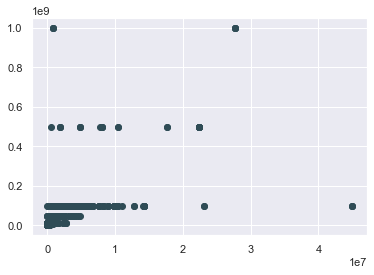

In [45]:
import matplotlib.pyplot as plt
#print(list(X_train['Size']))
#print(X_train['Installs'])
temp = map(int, X_train['Installs'])
#print(list(map(int, X_train['Reviews']))
#print(y)
#print(X_train['Reviews'])
plt.scatter(list(map(int, X_train['Reviews'])), list(map(int, X_train['Installs'])))


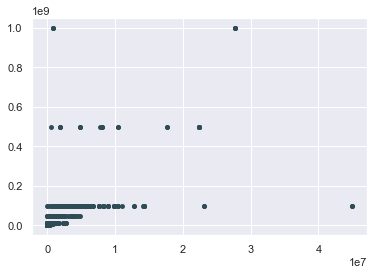

In [52]:
the_reviews = list(map(int, X_train['Reviews']))
the_installs = list(map(int, X_train['Installs']))
plt.scatter(the_reviews, the_installs, marker='o', s=15)
plt.show()

In [107]:
def print_cluster(model, n_clusters, X):
    y_km = model.fit_predict(X)
    color_list = ['lightgreen', 'orange', 'lightblue', 'red', 'yellow', 'brown', 'cyan']
    plt.figure(figsize=(8,8))
    for i in range(n_clusters):
        plt.scatter(X[y_km == i, 0],
        X[y_km == i, 1],
        s=50,
        c=color_list[i],
        marker='s',
        label='cluster ' + str(i))
    plt.legend()
    plt.xlabel('reviews (standardized)')
    plt.ylabel('installs (standardized)')
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=200, c='black', label = 'Centroids')    
    plt.show()

In [96]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

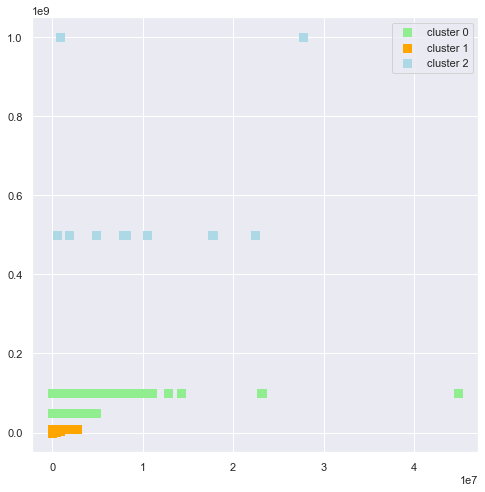

In [86]:
print_cluster(km, 3, np.array(list(zip(the_reviews, the_installs))))

In [97]:
scale = StandardScaler()
km_data_std = scale.fit_transform(list(zip(the_reviews, the_installs)))

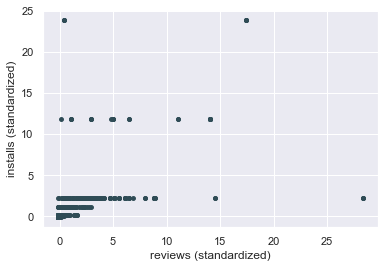

In [102]:
[[0] for i in km_data_std]
[[1] for i in km_data_std]
plt.scatter([i[0] for i in km_data_std], [i[1] for i in km_data_std], marker='o', s=15)
plt.xlabel('reviews (standardized)')
plt.ylabel('installs (standardized)')
plt.show()

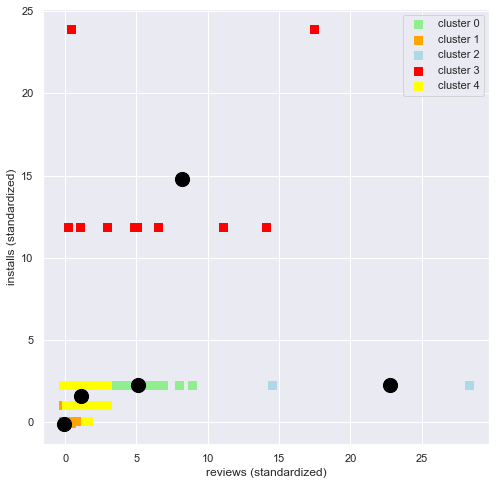

In [108]:
print_cluster(km, 5, km_data_std)

In [76]:
def plot_distortions(data):
    distortions = []
    for i in range(1, 11):
        km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(1, 11), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

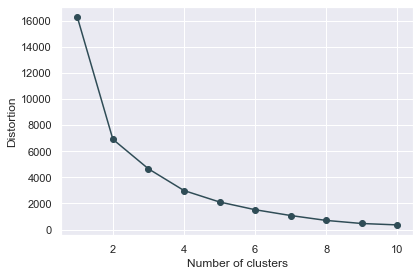

In [77]:
plot_distortions(km_data_std)